In [1]:
import numpy as np 
import pandas as pd 

from sklearn.utils import resample # équilibrage de classes

# Préparation des données pour entrainement
from sklearn.model_selection import train_test_split

# Paramètres du modèle
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# sauvegarde des hyperparamètres
import pickle

# Explicabilité
import shap

In [56]:
def load_data(filepath, drop_columns=None):
    """Charge les données depuis un fichier CSV et supprime les colonnes indésirées."""
    df = pd.read_csv(filepath)
    if drop_columns is not None:
        df = df.drop(columns=drop_columns)
    return df

def sort_dataset_by_patient_and_hour(df, patient_id_column='Patient_ID', hour_column='Hour'):
    """
    Trie le DataFrame en fonction des colonnes spécifiées pour Patient_ID et Hour, 
    assurant que les données sont triées d'abord par patient, puis par heure pour chaque patient.

    Args:
    df (DataFrame): Le DataFrame à trier.
    patient_id_column (str): Nom de la colonne contenant les identifiants des patients.
    hour_column (str): Nom de la colonne contenant les heures des prises de mesures.

    Returns:
    DataFrame: Un DataFrame trié selon les identifiants des patients et les heures.
    """
    sorted_df = df.sort_values(by=[patient_id_column, hour_column])
    return sorted_df


def aggregate_sepsis_label(df, patient_id_column='Patient_ID', sepsis_label_column='SepsisLabel'):
    """
    Agrège les données pour chaque patient pour déterminer si le patient a eu un sepsis
    à un moment quelconque et ajoute cette information dans une nouvelle colonne.

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.
    patient_id_column (str): Le nom de la colonne contenant les identifiants des patients.
    sepsis_label_column (str): Le nom de la colonne contenant les étiquettes de sepsis.

    Returns:
    DataFrame: Un DataFrame enrichi avec une colonne indiquant si le patient a eu un sepsis.
    """
    # Aggrégation des données par patient avec le maximum de SepsisLabel
    aggregated_df = df.groupby(patient_id_column)[sepsis_label_column].max().reset_index()

    # Renommer la colonne pour clarifier qu'il s'agit du résultat de l'aggrégation
    aggregated_df = aggregated_df.rename(columns={sepsis_label_column: 'will_have_sepsis'})

    # Joindre avec les données originales pour obtenir un DataFrame complet par patient
    aggregated_full_df = df.merge(aggregated_df, on=patient_id_column)

    return aggregated_full_df


def display_basic_info(df):
    """Affiche les informations de base sur le DataFrame, y compris sa forme, ses colonnes,
    un résumé descriptif, les valeurs manquantes par colonne et les premières lignes."""
    
    print("Shape of the DataFrame:", df.shape)
    print('\nNumbre of unique patients :', df['Patient_ID'].nunique())
    if 'SepsisLabel' in df.columns:
        print("\nLignes classes counts : ", df['SepsisLabel'].value_counts())
    if 'will_have_sepsis' in df.columns:
        print('\nClasses counts : ', df['will_have_sepsis'].value_counts())
    print("\nColumns in the DataFrame:", df.columns)
    print("\nData Types:\n", df.dtypes)
    display("Descriptive Statistics:", df.describe())
    print("\nMissing Values Per Column:\n", df.isna().sum())
    display("First 5 Rows of the DataFrame:", df.head())
    
    


def clean_data(df, interest_columns=None, missing_value_threshold=0.3):
    """Nettoie le DataFrame en supprimant les lignes avec trop de valeurs manquantes.
    Si 'interest_columns' n'est pas spécifié, toutes les colonnes sont prises en compte."""
    
    if interest_columns is None:
        interest_columns = df.columns.tolist()
    seuil = missing_value_threshold * len(interest_columns)
    cleaned_df = df.dropna(subset=interest_columns, thresh=len(interest_columns) - seuil)
    return cleaned_df


def balance_classes(df, target_column, method='undersample', random_state=123):
    """
    Équilibre les classes dans un DataFrame en sous-échantillonnant la classe majoritaire ou 
    en sur-échantillonnant la classe minoritaire selon le paramètre 'method'.

    Args:
    df (DataFrame): Le DataFrame à équilibrer.
    target_column (str): Nom de la colonne contenant les étiquettes de classe.
    method (str): Méthode d'équilibrage, 'undersample' pour sous-échantillonnage ou 'oversample' pour sur-échantillonnage.
    random_state (int): Graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    DataFrame: Un DataFrame où les classes sont équilibrées.
    """
    # Identifier les classes majoritaire et minoritaire
    class_counts = df[target_column].value_counts()
    major_class_label = class_counts.idxmax()
    minor_class_label = class_counts.idxmin()

    major_class = df[df[target_column] == major_class_label]
    minor_class = df[df[target_column] == minor_class_label]

    if method == 'undersample':
        # Sous-échantillonnage de la classe majoritaire
        resampled_major_class = resample(major_class,
                                         replace=False,
                                         n_samples=len(minor_class),
                                         random_state=random_state)
        balanced_df = pd.concat([resampled_major_class, minor_class])
    elif method == 'oversample':
        # Sur-échantillonnage de la classe minoritaire
        resampled_minor_class = resample(minor_class,
                                         replace=True,
                                         n_samples=len(major_class),
                                         random_state=random_state)
        balanced_df = pd.concat([major_class, resampled_minor_class])

    return balanced_df

def balance_data_by_sepsis_label(df):
    """
    Équilibre les données en sélectionnant le même nombre de patients ayant 0 et 1 comme valeur de 'will_have_sepsis'.

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.

    Returns:
    DataFrame: Un DataFrame équilibré avec un nombre égal de patients ayant 0 et 1 comme valeur de 'will_have_sepsis'.
    """
    # Séparer les patients ayant 0 et 1 comme valeur de 'will_have_sepsis'
    sepsis_positive = df[df['will_have_sepsis'] == 1]
    sepsis_negative = df[df['will_have_sepsis'] == 0]

    # Trouver le nombre minimal de patients dans les deux groupes
    min_count = min(len(sepsis_positive), len(sepsis_negative))

    # Échantillonner de manière aléatoire un nombre égal de patients de chaque groupe
    sepsis_positive_sample = sepsis_positive.sample(n=min_count, random_state=42)
    sepsis_negative_sample = sepsis_negative.sample(n=min_count, random_state=42)

    # Combiner les échantillons pour créer un DataFrame équilibré
    balanced_df = pd.concat([sepsis_positive_sample, sepsis_negative_sample])

    return balanced_df

def split_train_test_data(df, test_size=0.2, random_seed=42):
    """
    Sépare les données en ensembles d'entraînement et de test, en s'assurant que les patients
    avec et sans sepsis sont correctement répartis sans chevauchement entre les ensembles.

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.
    test_size (float): La proportion de chaque groupe de patients à utiliser pour le test.
    random_seed (int): La graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    tuple: Un tuple contenant deux DataFrames, (train_df, test_df).
    """
    np.random.seed(random_seed)  # Pour la reproductibilité

    # Identifier les patients qui ont eu un sepsis
    patients_with_sepsis = df[df['will_have_sepsis'] == 1]['Patient_ID'].unique()

    # Sélectionner une proportion pour le test parmi les patients avec sepsis
    test_patients_with_sepsis = np.random.choice(patients_with_sepsis, size=int(len(patients_with_sepsis) * test_size), replace=False)

    # Identifier et sélectionner une proportion pour le test parmi les patients sans sepsis
    patients_without_sepsis = df[df['will_have_sepsis'] == 0]['Patient_ID'].unique()
    test_patients_without_sepsis = np.random.choice(patients_without_sepsis, size=int(len(patients_without_sepsis) * test_size), replace=False)

    # Combiner les patients de test
    test_patients = np.concatenate((test_patients_with_sepsis, test_patients_without_sepsis))

    # Créer les ensembles de données
    train_df = df[~df['Patient_ID'].isin(test_patients)]
    test_df = df[df['Patient_ID'].isin(test_patients)]

    return train_df, test_df

def add_time_to_sepsis_column(df):
    # Trouver le premier instant où chaque patient a SepsisLabel = 1
    first_sepsis_time = df[df['SepsisLabel'] == 1].groupby('Patient_ID')['Hour'].min()

    # Mapper ces temps de première sepsis sur les patients dans le DataFrame
    df['time_to_first_sepsis'] = df['Patient_ID'].map(first_sepsis_time)

    # Calculer time_to_sepsis comme la différence entre l'heure de la première sepsis et HospAdmTime
    # Note: Assurez-vous que 'HospAdmTime' est bien l'heure d'admission initiale pour chaque patient.
    # Si 'HospAdmTime' change par patient et enregistrement, cela devrait être ajusté en conséquence.
    df['time_to_sepsis'] = df['time_to_first_sepsis']  # - df['HospAdmTime']

    # Supprimer la colonne intermédiaire 'time_to_first_sepsis' si non nécessaire
    df.drop(columns=['time_to_first_sepsis'], inplace=True)

    return df

def filter_rows_by_time_to_sepsis(df, time_window = 24):
    """
    Filtre les lignes du DataFrame pour conserver uniquement celles où 'time_to_sepsis' est NaN,
    ou celles où 'Hour' est compris entre 'time_to_sepsis + HospAdmTime' et 'time_to_sepsis + HospAdmTime - 24'.

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.
    time_window (int) : fenêtre temporelle à récupérer
    
    Returns:
    DataFrame: Un DataFrame filtré avec les lignes désirées.
    """
    # Filtrer les lignes où 'time_to_sepsis' est NaN
    nan_time_to_sepsis_df = df[df['time_to_sepsis'].isna()]

    # Filtrer les lignes où 'Hour' est dans l'intervalle spécifié
    non_nan_time_to_sepsis_df = df.dropna(subset=['time_to_sepsis'])
    filtered_df = non_nan_time_to_sepsis_df[
        (non_nan_time_to_sepsis_df['Hour'] >= non_nan_time_to_sepsis_df['time_to_sepsis'] + non_nan_time_to_sepsis_df['HospAdmTime'] - time_window) &
        (non_nan_time_to_sepsis_df['Hour'] <= non_nan_time_to_sepsis_df['time_to_sepsis'] + non_nan_time_to_sepsis_df['HospAdmTime'])
    ]

    # Combiner les DataFrames filtrés
    combined_df = pd.concat([nan_time_to_sepsis_df, filtered_df])

    return combined_df


def filter_rows_by_time_to_sepsis_min_max(df, min_time=6, max_time=12):
    """
    Filtre les lignes du DataFrame pour conserver uniquement celles où 'time_to_sepsis' est NaN,
    ou entre un minimum et un maximum spécifié (inclus).

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.
    min_time (int): La valeur minimale de 'time_to_sepsis' pour conserver la ligne.
    max_time (int): La valeur maximale de 'time_to_sepsis' pour conserver la ligne.

    Returns:
    DataFrame: Un DataFrame filtré avec les lignes désirées.
    """
    # Filtrer le DataFrame pour conserver les lignes où 'time_to_sepsis' est NaN ou dans l'intervalle spécifié
    filtered_df = df[(df['time_to_sepsis'].isna()) |
                     ((df['time_to_sepsis'] >= min_time) & (df['time_to_sepsis'] <= max_time))]
    return filtered_df

def filter_rows_by_time_to_sepsis_min(df, min_time=6):
    """
    Filtre les lignes du DataFrame pour conserver uniquement celles où 'time_to_sepsis' est NaN,
    ou entre un minimum et un maximum spécifié (inclus).

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.
    min_time (int): La valeur minimale de 'time_to_sepsis' pour conserver la ligne.
    max_time (int): La valeur maximale de 'time_to_sepsis' pour conserver la ligne.

    Returns:
    DataFrame: Un DataFrame filtré avec les lignes désirées.
    """
    # Filtrer le DataFrame pour conserver les lignes où 'time_to_sepsis' est NaN ou dans l'intervalle spécifié
    filtered_df = df[(df['time_to_sepsis'].isna()) | (df['time_to_sepsis'] >= min_time)]
    return filtered_df

def add_sepsis_label_12(df):
    """
    Ajoute une colonne 'SepsisLabel_12' au DataFrame, qui a les mêmes valeurs que 'will_have_sepsis'
    sauf pour les lignes où 'Hour' < ('time_to_sepsis' - 12), qui auront la valeur 0, tout en gérant les valeurs NaN.

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.

    Returns:
    DataFrame: Le DataFrame avec la nouvelle colonne 'SepsisLabel_12'.
    """
    # Copier la colonne 'will_have_sepsis' dans 'SepsisLabel_12'
    df['SepsisLabel_12'] = df['will_have_sepsis']

    # Mettre à jour les valeurs de 'SepsisLabel_12' en fonction de la condition
    condition = (df['time_to_sepsis'].notna()) & (df['Hour'] < (df['time_to_sepsis'] - 12))
    df.loc[condition, 'SepsisLabel_12'] = 0

    return df

In [3]:
# Découpage de l'ensemble d'entrainement et de test
def prepare_train_test(df, label_column, test_size=0.2, random_state=None, stratify=True):
    """
    Prépare les ensembles d'entraînement et de test à partir d'un DataFrame donné.

    Args:
    df (DataFrame): Le DataFrame à partir duquel les ensembles doivent être créés.
    label_column (str): Le nom de la colonne qui contient les étiquettes cibles.
    test_size (float): La proportion du dataset à inclure dans l'ensemble de test.
    random_state (int): Contrôle la reproductibilité des résultats en fixant un seed pour le générateur aléatoire.
    stratify (bool): Si True, les données sont divisées de façon à préserver le même pourcentage pour chaque classe cible dans les ensembles de train et de test.

    Returns:
    tuple: Contient les ensembles X_train, X_test, y_train, y_test.
    """
    # Séparation des features et des étiquettes
    X = df.drop(columns=[label_column])
    y = df[label_column]

    # Stratification optionnelle basée sur les étiquettes
    stratify_param = y if stratify else None

    # Répartition des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        stratify=stratify_param, random_state=random_state)
    
    # Affichage des dimensions des ensembles pour vérification
    print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)

    return X_train, X_test, y_train, y_test


def objective(trial, X, y, cv=7):
    """
    Fonction objectif pour l'optimisation d'hyperparamètres avec Optuna.

    Args:
    trial (optuna.trial): Un essai de Optuna pour suggérer les hyperparamètres.
    X (DataFrame): Features du dataset.
    y (Series): Étiquettes cibles du dataset.
    cv (int): Nombre de plis pour la validation croisée.

    Returns:
    float: La moyenne des scores de validation croisée pour les hyperparamètres suggérés.
    """
    # Hyperparamètres suggérés par Optuna
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 2, 15)
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_uniform('gamma', 0.01, 5)
    subsample = trial.suggest_uniform('subsample', 0.01, 1)
    
    # Création et évaluation du modèle
    clf = XGBClassifier(learning_rate=learning_rate,
                        max_depth=max_depth,
                        n_estimators=n_estimators,
                        min_child_weight=min_child_weight,
                        gamma=gamma,
                        subsample=subsample,
                        use_label_encoder=False,
                        eval_metric='logloss')
    
    # Calcul du score moyen sur les plis de validation croisée
    score = cross_val_score(clf, X, y, cv=cv)
    
    return np.mean(score)


def perform_hyperparameter_optimization(X, y, objective, n_trials=50, random_state=42):
    """
    Crée une étude Optuna pour optimiser les hyperparamètres d'un modèle de machine learning.

    Args:
    X (DataFrame): Les features d'entrée pour le modèle.
    y (Series): Les étiquettes cibles.
    objective (function): La fonction objective pour Optuna.
    n_trials (int): Le nombre de tentatives d'optimisation.
    random_state (int): Graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    dict: Meilleurs hyperparamètres trouvés par l'étude Optuna.
    """
    # Création d'un objet study d'Optuna
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_state))
    
    # Lancement de l'optimisation
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)

    # Retourne les meilleurs paramètres trouvés
    return study.best_params, study

# sauvegarde des meilleurs hyperparamètres
def save_study(study, filename):
    with open(filename, 'wb') as f:
        pickle.dump(study, f)

# chargement des meilleurs hyperparamètres
def load_study(filename):
    with open(filename, 'rb') as f:
        study = pickle.load(f)
    return study

def train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path):
    """
    Crée, entraîne et sauvegarde un modèle XGBoost avec des paramètres spécifiés.

    Args:
    X_train (DataFrame): Les features d'entraînement.
    y_train (Series): Les étiquettes cibles d'entraînement.
    best_params (dict): Dictionnaire contenant les meilleurs paramètres pour le modèle.
    model_path (str): Chemin du fichier où le modèle sera sauvegardé.

    Returns:
    XGBClassifier: Le modèle XGBoost entraîné.
    """
    xgbc = XGBClassifier(
        n_jobs=-1,  # Utiliser tous les processeurs disponible
        tree_method='hist',  # Utiliser 'hist' pour accélérer l'entraînement
        subsample=0.8,       # Sous-échantillonnage pour réduire le temps d'entraînement
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        #subsample=best_params['subsample'],
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Entraînement du modèle
    xgbc.fit(X_train, y_train)

    # Sauvegarde du modèle
    with open(model_path, 'wb') as file:
        pickle.dump(xgbc, file)

    return xgbc


def predict_and_evaluate(model, X_test, y_test):
    """
    Fait des prédictions avec un modèle donné et évalue les résultats.

    Args:
    model (XGBClassifier): Le modèle entraîné à utiliser pour les prédictions.
    X_test (DataFrame): Les features de test.
    y_test (Series): Les étiquettes cibles de test.

    Returns:
    str: Un rapport d'évaluation imprimable.
    """
    # Prédiction avec le modèle
    y_predicted = model.predict(X_test)

    # Génération du rapport d'évaluation
    evaluation_report = classification_report(y_test, y_predicted)

    return evaluation_report


def explain_model_predictions_with_shap(model, X_train, X_test):
    """
    Explique les prédictions d'un modèle XGBoost en utilisant SHAP.

    Args:
    model (XGBClassifier): Le modèle entraîné.
    X_train (DataFrame): Les données d'entraînement.
    X_test (DataFrame): Les données de test pour lesquelles les explications sont générées.

    Returns:
    None: Affiche les graphiques SHAP.
    """
    # Création d'un explainer SHAP
    explainer = shap.Explainer(model, X_train)

    # Calcul des valeurs SHAP
    shap_values = explainer(X_test)

    # Affichage du summary plot
    shap.summary_plot(shap_values, X_test, plot_type="bar")


def load_xgboost_classifier(model_path):
    """
    Charge un modèle XGBoost sauvegardé à partir d'un fichier.

    Args:
    model_path (str): Chemin du fichier où le modèle est sauvegardé.

    Returns:
    XGBClassifier: Le modèle XGBoost chargé.
    """
    with open(model_path, 'rb') as file:
        xgbc_loaded = pickle.load(file)
    
    return xgbc_loaded

In [4]:
data = pd.read_csv('Dataset.csv')

In [5]:
data.drop(columns='Unnamed: 0', inplace=True)
data

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,21,83.0,99.0,NaN,121.0,77.0,54.0,22.0,NaN,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,22,0,113911
1552206,22,80.0,92.0,NaN,102.0,73.0,51.0,24.0,NaN,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,23,0,113911
1552207,23,95.0,97.0,36.7,128.5,83.0,58.5,25.0,NaN,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,24,0,113911
1552208,24,104.0,99.0,NaN,127.0,85.0,59.0,24.0,NaN,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,25,0,113911


In [86]:
df_24 = data[data['Hour'] < 25]

In [87]:
df_24['SepsisLabel'].value_counts()

SepsisLabel
0    925376
1     11944
Name: count, dtype: int64

In [90]:
df_sep = df_24[df_24['SepsisLabel'] == 1]

In [91]:
df_sep['Patient_ID'].nunique()

1397

In [96]:
df_sep['Patient_ID'].value_counts().unique()

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1], dtype=int64)

In [94]:
df_sep.shape

(11944, 43)

In [6]:
df_sorted = sort_dataset_by_patient_and_hour(data)
df_aggregated = aggregate_sepsis_label(df_sorted)
df_aggregated

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,1,0,1,0
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,2,0,1,0
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,3,0,1,0
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,NaN,83.14,0,NaN,NaN,-0.03,4,0,1,0
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,30,80.0,96.0,NaN,115.0,87.00,65.0,15.0,NaN,NaN,...,NaN,62.00,0,NaN,NaN,0.00,31,0,120000,0
1552206,31,74.0,97.0,NaN,114.0,83.00,67.0,15.0,NaN,NaN,...,NaN,62.00,0,NaN,NaN,0.00,32,0,120000,0
1552207,32,78.0,98.0,NaN,110.0,83.00,69.0,15.0,NaN,NaN,...,NaN,62.00,0,NaN,NaN,0.00,33,0,120000,0
1552208,33,82.0,99.0,36.6,124.0,91.00,71.0,16.0,NaN,NaN,...,NaN,62.00,0,NaN,NaN,0.00,34,0,120000,0


In [40]:
df_augm = add_time_to_sepsis_column(df_aggregated)
df_augm

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,1,0,1,0,NaN
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,2,0,1,0,NaN
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,3,0,1,0,NaN
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,83.14,0,NaN,NaN,-0.03,4,0,1,0,NaN
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,5,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,30,80.0,96.0,NaN,115.0,87.00,65.0,15.0,NaN,NaN,...,62.00,0,NaN,NaN,0.00,31,0,120000,0,NaN
1552206,31,74.0,97.0,NaN,114.0,83.00,67.0,15.0,NaN,NaN,...,62.00,0,NaN,NaN,0.00,32,0,120000,0,NaN
1552207,32,78.0,98.0,NaN,110.0,83.00,69.0,15.0,NaN,NaN,...,62.00,0,NaN,NaN,0.00,33,0,120000,0,NaN
1552208,33,82.0,99.0,36.6,124.0,91.00,71.0,16.0,NaN,NaN,...,62.00,0,NaN,NaN,0.00,34,0,120000,0,NaN


In [84]:
df_sepsis = df_augm[df_augm['will_have_sepsis'] == 1]
df_sepsis[df_sepsis['Patient_ID'] == 9]

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis
304,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.92,1,NaN,NaN,-0.03,1,0,9,1,248.0
305,1,117.0,99.0,NaN,116.0,97.0,81.0,20.0,NaN,NaN,...,27.92,1,NaN,NaN,-0.03,2,0,9,1,248.0
306,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.0,...,27.92,1,NaN,NaN,-0.03,3,0,9,1,248.0
307,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,...,27.92,1,NaN,NaN,-0.03,4,0,9,1,248.0
308,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,...,27.92,1,NaN,NaN,-0.03,5,0,9,1,248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.92,1,NaN,NaN,-0.03,254,1,9,1,248.0
558,254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,...,27.92,1,NaN,NaN,-0.03,255,1,9,1,248.0
559,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.92,1,NaN,NaN,-0.03,256,1,9,1,248.0
560,256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,27.92,1,NaN,NaN,-0.03,257,1,9,1,248.0


In [74]:
sepsis_out_icu = df_sepsis[df_sepsis['time_to_sepsis'] < 1]
sepsis_out_icu

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis,SepsisLabel_12
794216,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.0,0.0,0.0,1,1,100104,1,0.0,1
815014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,0.0,1,1,100645,1,0.0,1
851516,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,0.0,1,1,101598,1,0.0,1
875072,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,0.0,1,1,102236,1,0.0,1
875224,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,0.0,1,1,102240,1,0.0,1
878565,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1.0,0.0,0.0,1,1,102332,1,0.0,1
882975,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,0.0,1,1,102453,1,0.0,1
910603,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.0,1.0,0.0,1,1,103197,1,0.0,1
913174,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,0.0,1,1,103265,1,0.0,1
914403,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,0.0,1,1,103297,1,0.0,1


In [77]:
sepsis_out_icu['Patient_ID'].unique()

array([100104, 100645, 101598, 102236, 102240, 102332, 102453, 103197,
       103265, 103297, 103586, 104066, 104354, 104500, 105456, 105732,
       106424, 106485, 106662, 106933, 107137, 107255, 107844, 108015,
       109630, 110127, 110445, 110866, 110991, 111206, 111695, 111860,
       112347, 112802, 113150, 113683, 113800, 114239, 115876, 116171,
       116780, 117083, 117114, 117179, 118844, 119010, 119173, 119678],
      dtype=int64)

In [80]:
sepsis_out_icu[sepsis_out_icu['Patient_ID'] == 110445]

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis,SepsisLabel_12
1186121,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.0,1.0,0.0,1,1,110445,1,0.0,1


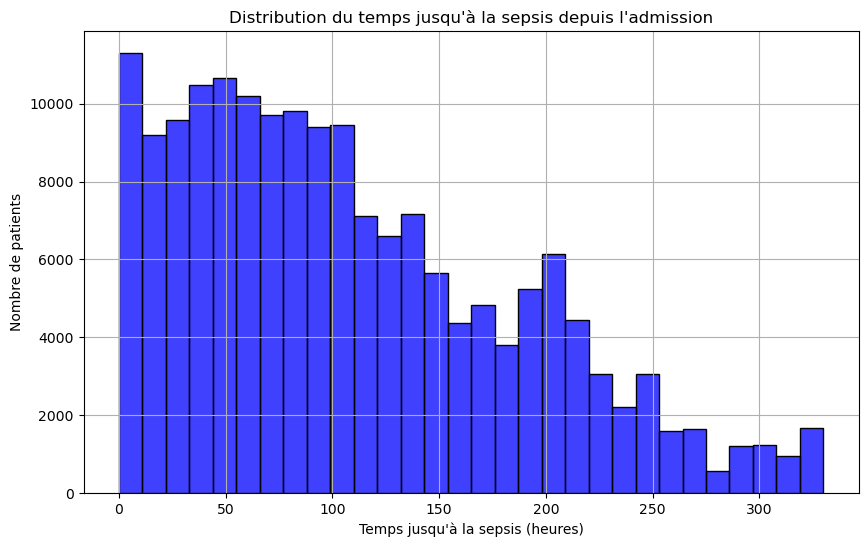

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
# Créer l'histogramme
plt.figure(figsize=(10, 6))
sns.histplot(df_sepsis['time_to_sepsis'], bins=30, kde=False, color='blue')
plt.title('Distribution du temps jusqu\'à la sepsis depuis l\'admission')
plt.xlabel('Temps jusqu\'à la sepsis (heures)')
plt.ylabel('Nombre de patients')
plt.grid(True)
plt.show()

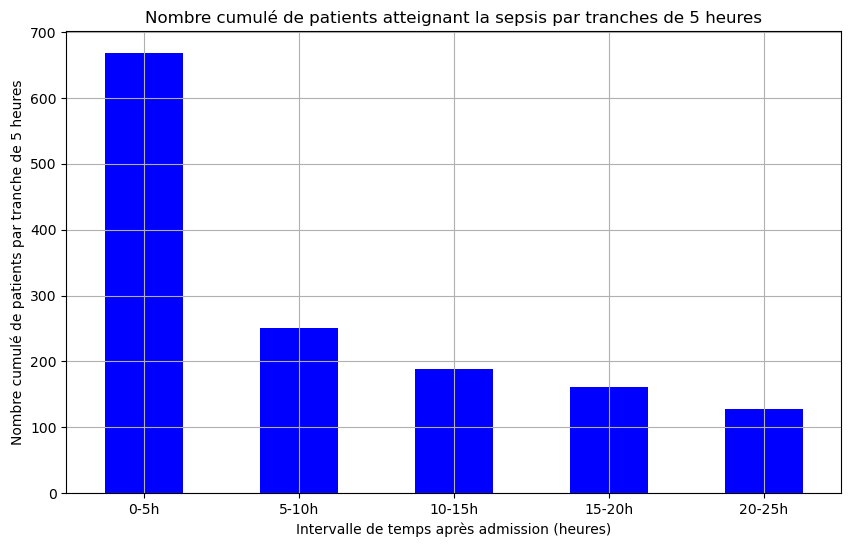

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Agréger les données pour obtenir le temps minimal jusqu'à la sepsis pour chaque patient unique
df_sepsis_min_time = df_sepsis.groupby('Patient_ID')['time_to_sepsis'].min().reset_index()

# Définir les intervalles de 5 heures
bins = [0, 5, 10, 15, 20, 25]

# Créer une nouvelle colonne pour les tranches horaires
df_sepsis_min_time['time_interval'] = pd.cut(df_sepsis_min_time['time_to_sepsis'], bins, right=False, labels=["0-5h", "5-10h", "10-15h", "15-20h", "20-25h"])

# Compter les patients dans chaque intervalle
interval_counts = df_sepsis_min_time['time_interval'].value_counts().sort_index()

# Calculer les cumuls pour chaque intervalle de manière indépendante
# Cela implique de recalculer les cumuls pour chaque bin comme une somme des bins précédents uniquement
cumulative_counts = interval_counts.cumsum() - interval_counts.cumsum().shift(1).fillna(0)

# Créer l'histogramme cumulatif
plt.figure(figsize=(10, 6))
cumulative_counts.plot(kind='bar', color='blue')
plt.title('Nombre cumulé de patients atteignant la sepsis par tranches de 5 heures')
plt.xlabel('Intervalle de temps après admission (heures)')
plt.ylabel('Nombre cumulé de patients par tranche de 5 heures')
plt.xticks(rotation=0)  # Ajuster l'orientation des labels de l'axe x si nécessaire
plt.grid(True)
plt.show()


In [44]:
display_basic_info(df_augm)

Shape of the DataFrame: (1552210, 45)

Numbre of unique patients : 40336

Lignes classes counts :  SepsisLabel
0    1524294
1      27916
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    1379800
1     172410
Name: count, dtype: int64

Columns in the DataFrame: Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis', 'time_to_sepsis'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP  

'Descriptive Statistics:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis
count,1.552210e+06,1.398811e+06,1.349474e+06,525226.000000,1.325945e+06,1.358940e+06,1.065656e+06,1.313875e+06,57636.000000,84145.000000,...,1.552210e+06,1.552210e+06,940250.000000,940250.000000,1.552202e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,172410.000000
mean,2.549274e+01,8.458144e+01,9.719395e+01,36.977228,1.237505e+02,8.240010e+01,6.383056e+01,1.872650e+01,32.957657,-0.689919,...,6.200947e+01,5.592690e-01,0.496571,0.503429,-5.612512e+01,2.699499e+01,1.798468e-02,5.920148e+04,1.110739e-01,108.744696
std,2.888256e+01,1.732524e+01,2.936924e+00,0.770014,2.323156e+01,1.634175e+01,1.395601e+01,5.098194e+00,7.951662,4.294297,...,1.638622e+01,4.964749e-01,0.499989,0.499989,1.622569e+02,2.900542e+01,1.328956e-01,5.024819e+04,3.142237e-01,77.900507
min,0.000000e+00,2.000000e+01,2.000000e+01,20.900000,2.000000e+01,2.000000e+01,2.000000e+01,1.000000e+00,10.000000,-32.000000,...,1.400000e+01,0.000000e+00,0.000000,0.000000,-5.366860e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000
25%,9.000000e+00,7.200000e+01,9.600000e+01,36.500000,1.070000e+02,7.100000e+01,5.400000e+01,1.500000e+01,28.000000,-3.000000,...,5.168000e+01,0.000000e+00,0.000000,0.000000,-4.705000e+01,1.100000e+01,0.000000e+00,9.990000e+03,0.000000e+00,46.000000
50%,1.900000e+01,8.350000e+01,9.800000e+01,37.000000,1.210000e+02,8.000000e+01,6.200000e+01,1.800000e+01,33.000000,0.000000,...,6.400000e+01,1.000000e+00,0.000000,1.000000,-6.030000e+00,2.100000e+01,0.000000e+00,1.996500e+04,0.000000e+00,94.000000
75%,3.300000e+01,9.550000e+01,9.950000e+01,37.500000,1.380000e+02,9.200000e+01,7.200000e+01,2.150000e+01,38.000000,1.000000,...,7.400000e+01,1.000000e+00,1.000000,1.000000,-4.000000e-02,3.400000e+01,0.000000e+00,1.098780e+05,0.000000e+00,160.000000
max,3.350000e+02,2.800000e+02,1.000000e+02,50.000000,3.000000e+02,3.000000e+02,3.000000e+02,1.000000e+02,100.000000,100.000000,...,1.000000e+02,1.000000e+00,1.000000,1.000000,2.399000e+01,3.360000e+02,1.000000e+00,1.200000e+05,1.000000e+00,330.000000



Missing Values Per Column:
 Hour                      0
HR                   153399
O2Sat                202736
Temp                1026984
SBP                  226265
MAP                  193270
DBP                  486554
Resp                 238335
EtCO2               1494574
BaseExcess          1468065
HCO3                1487182
FiO2                1422845
pH                  1444637
PaCO2               1465909
SaO2                1498649
AST                 1527027
BUN                 1445642
Alkalinephos        1527269
Calcium             1460879
Chloride            1481744
Creatinine          1457594
Bilirubin_direct    1549220
Glucose             1286694
Lactate             1510764
Magnesium           1454259
Phosphate           1489909
Potassium           1407685
Bilirubin_total     1529069
TroponinI           1537429
Hct                 1414777
Hgb                 1437619
PTT                 1506511
WBC                 1452763
Fibrinogen          1541968
Platelets          

'First 5 Rows of the DataFrame:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,1,0,1,0,NaN
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,2,0,1,0,NaN
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,3,0,1,0,NaN
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,83.14,0,NaN,NaN,-0.03,4,0,1,0,NaN
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,5,0,1,0,NaN


In [45]:
df_with_time_window = filter_rows_by_time_to_sepsis(df_augm)
display_basic_info(df_with_time_window)

Shape of the DataFrame: (1413175, 45)

Numbre of unique patients : 39198

Lignes classes counts :  SepsisLabel
0    1413015
1        160
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    1379800
1      33375
Name: count, dtype: int64

Columns in the DataFrame: Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis', 'time_to_sepsis'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP  

'Descriptive Statistics:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis
count,1.413175e+06,1.269442e+06,1.223029e+06,475510.000000,1.205713e+06,1.231685e+06,960955.000000,1.192757e+06,42804.000000,71667.000000,...,1.413175e+06,1.413175e+06,868650.000000,868650.000000,1.413167e+06,1.413175e+06,1.413175e+06,1.413175e+06,1.413175e+06,33375.000000
mean,2.224472e+01,8.420920e+01,9.718442e+01,36.963800,1.237253e+02,8.245706e+01,63.960048,1.861936e+01,33.009742,-0.752270,...,6.197650e+01,5.567216e-01,0.495703,0.504297,-5.203643e+01,2.373712e+01,1.132202e-04,6.006604e+04,2.361703e-02,79.768390
std,2.223935e+01,1.715328e+01,2.926746e+00,0.753578,2.310783e+01,1.634917e+01,13.974490,4.998967e+00,8.087265,4.252526,...,1.641528e+01,4.967724e-01,0.499982,0.499982,1.510646e+02,2.238557e+01,1.063990e-02,5.025910e+04,1.518528e-01,64.031569
min,0.000000e+00,2.000000e+01,2.000000e+01,20.900000,2.000000e+01,2.000000e+01,20.000000,1.000000e+00,10.000000,-32.000000,...,1.400000e+01,0.000000e+00,0.000000,0.000000,-5.366860e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000
25%,9.000000e+00,7.200000e+01,9.600000e+01,36.500000,1.070000e+02,7.100000e+01,54.000000,1.500000e+01,28.500000,-3.000000,...,5.151000e+01,0.000000e+00,0.000000,0.000000,-4.367000e+01,1.000000e+01,0.000000e+00,1.014300e+04,0.000000e+00,32.000000
50%,1.900000e+01,8.300000e+01,9.800000e+01,37.000000,1.210000e+02,8.000000e+01,62.000000,1.800000e+01,33.000000,0.000000,...,6.400000e+01,1.000000e+00,0.000000,1.000000,-5.990000e+00,2.000000e+01,0.000000e+00,2.063200e+04,0.000000e+00,61.000000
75%,3.100000e+01,9.500000e+01,9.900000e+01,37.440000,1.380000e+02,9.200000e+01,72.000000,2.100000e+01,38.000000,1.000000,...,7.400000e+01,1.000000e+00,1.000000,1.000000,-4.000000e-02,3.300000e+01,0.000000e+00,1.100320e+05,0.000000e+00,109.000000
max,3.350000e+02,2.800000e+02,1.000000e+02,50.000000,3.000000e+02,3.000000e+02,300.000000,1.000000e+02,100.000000,100.000000,...,1.000000e+02,1.000000e+00,1.000000,1.000000,2.399000e+01,3.360000e+02,1.000000e+00,1.200000e+05,1.000000e+00,330.000000



Missing Values Per Column:
 Hour                      0
HR                   143733
O2Sat                190146
Temp                 937665
SBP                  207462
MAP                  181490
DBP                  452220
Resp                 220418
EtCO2               1370371
BaseExcess          1341508
HCO3                1356046
FiO2                1307006
pH                  1321380
PaCO2               1339907
SaO2                1366622
AST                 1391258
BUN                 1317912
Alkalinephos        1391500
Calcium             1332310
Chloride            1351475
Creatinine          1328120
Bilirubin_direct    1410625
Glucose             1173064
Lactate             1379414
Magnesium           1326335
Phosphate           1358419
Potassium           1284888
Bilirubin_total     1392885
TroponinI           1399368
Hct                 1289500
Hgb                 1310219
PTT                 1372917
WBC                 1324053
Fibrinogen          1404446
Platelets          

'First 5 Rows of the DataFrame:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,1,0,1,0,NaN
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,2,0,1,0,NaN
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,3,0,1,0,NaN
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,83.14,0,NaN,NaN,-0.03,4,0,1,0,NaN
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,5,0,1,0,NaN


In [46]:
data_final_completed = add_sepsis_label_12(df_with_time_window)
display_basic_info(data_final_completed)

Shape of the DataFrame: (1413175, 46)

Numbre of unique patients : 39198

Lignes classes counts :  SepsisLabel
0    1413015
1        160
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    1379800
1      33375
Name: count, dtype: int64

Columns in the DataFrame: Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis', 'time_to_sepsis', 'SepsisLabel_12'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP            

'Descriptive Statistics:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis,SepsisLabel_12
count,1.413175e+06,1.269442e+06,1.223029e+06,475510.000000,1.205713e+06,1.231685e+06,960955.000000,1.192757e+06,42804.000000,71667.000000,...,1.413175e+06,868650.000000,868650.000000,1.413167e+06,1.413175e+06,1.413175e+06,1.413175e+06,1.413175e+06,33375.000000,1.413175e+06
mean,2.224472e+01,8.420920e+01,9.718442e+01,36.963800,1.237253e+02,8.245706e+01,63.960048,1.861936e+01,33.009742,-0.752270,...,5.567216e-01,0.495703,0.504297,-5.203643e+01,2.373712e+01,1.132202e-04,6.006604e+04,2.361703e-02,79.768390,1.018628e-02
std,2.223935e+01,1.715328e+01,2.926746e+00,0.753578,2.310783e+01,1.634917e+01,13.974490,4.998967e+00,8.087265,4.252526,...,4.967724e-01,0.499982,0.499982,1.510646e+02,2.238557e+01,1.063990e-02,5.025910e+04,1.518528e-01,64.031569,1.004118e-01
min,0.000000e+00,2.000000e+01,2.000000e+01,20.900000,2.000000e+01,2.000000e+01,20.000000,1.000000e+00,10.000000,-32.000000,...,0.000000e+00,0.000000,0.000000,-5.366860e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,9.000000e+00,7.200000e+01,9.600000e+01,36.500000,1.070000e+02,7.100000e+01,54.000000,1.500000e+01,28.500000,-3.000000,...,0.000000e+00,0.000000,0.000000,-4.367000e+01,1.000000e+01,0.000000e+00,1.014300e+04,0.000000e+00,32.000000,0.000000e+00
50%,1.900000e+01,8.300000e+01,9.800000e+01,37.000000,1.210000e+02,8.000000e+01,62.000000,1.800000e+01,33.000000,0.000000,...,1.000000e+00,0.000000,1.000000,-5.990000e+00,2.000000e+01,0.000000e+00,2.063200e+04,0.000000e+00,61.000000,0.000000e+00
75%,3.100000e+01,9.500000e+01,9.900000e+01,37.440000,1.380000e+02,9.200000e+01,72.000000,2.100000e+01,38.000000,1.000000,...,1.000000e+00,1.000000,1.000000,-4.000000e-02,3.300000e+01,0.000000e+00,1.100320e+05,0.000000e+00,109.000000,0.000000e+00
max,3.350000e+02,2.800000e+02,1.000000e+02,50.000000,3.000000e+02,3.000000e+02,300.000000,1.000000e+02,100.000000,100.000000,...,1.000000e+00,1.000000,1.000000,2.399000e+01,3.360000e+02,1.000000e+00,1.200000e+05,1.000000e+00,330.000000,1.000000e+00



Missing Values Per Column:
 Hour                      0
HR                   143733
O2Sat                190146
Temp                 937665
SBP                  207462
MAP                  181490
DBP                  452220
Resp                 220418
EtCO2               1370371
BaseExcess          1341508
HCO3                1356046
FiO2                1307006
pH                  1321380
PaCO2               1339907
SaO2                1366622
AST                 1391258
BUN                 1317912
Alkalinephos        1391500
Calcium             1332310
Chloride            1351475
Creatinine          1328120
Bilirubin_direct    1410625
Glucose             1173064
Lactate             1379414
Magnesium           1326335
Phosphate           1358419
Potassium           1284888
Bilirubin_total     1392885
TroponinI           1399368
Hct                 1289500
Hgb                 1310219
PTT                 1372917
WBC                 1324053
Fibrinogen          1404446
Platelets          

'First 5 Rows of the DataFrame:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis,SepsisLabel_12
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,-0.03,1,0,1,0,NaN,0
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,0,NaN,NaN,-0.03,2,0,1,0,NaN,0
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,0,NaN,NaN,-0.03,3,0,1,0,NaN,0
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,0,NaN,NaN,-0.03,4,0,1,0,NaN,0
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,0,NaN,NaN,-0.03,5,0,1,0,NaN,0


In [71]:
df_sepsis = data_final_completed[data_final_completed['will_have_sepsis'] == 1]


In [72]:
df_sepsis['Patient_ID'].nunique()

1794

In [57]:
# df_with_time_window.to_csv('df_with_time_window_24.csv', index=False)
data_final_completed.to_csv('data_final_completed_24.csv', index=False)

In [48]:
display_basic_info(df_sepsis)

Shape of the DataFrame: (33375, 46)

Numbre of unique patients : 1794

Lignes classes counts :  SepsisLabel
0    33215
1      160
Name: count, dtype: int64

Classes counts :  will_have_sepsis
1    33375
Name: count, dtype: int64

Columns in the DataFrame: Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis', 'time_to_sepsis', 'SepsisLabel_12'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP      

'Descriptive Statistics:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis,SepsisLabel_12
count,33375.000000,30869.000000,30176.000000,11198.000000,28342.000000,30312.000000,24157.000000,29031.000000,3282.000000,2831.000000,...,33375.000000,15860.000000,15860.000000,33375.000000,33375.000000,33375.000000,33375.000000,33375.0,33375.000000,33375.000000
mean,59.382742,87.504600,97.361231,37.102614,124.905858,82.332886,63.186875,19.891581,32.810329,-0.204733,...,0.607101,0.594451,0.405549,-9.115249,61.244794,0.004794,45245.417318,1.0,79.768390,0.431311
std,59.936291,18.354336,2.927614,0.906985,23.990728,15.998191,13.703154,5.810553,7.386182,4.519663,...,0.488402,0.491013,0.491013,23.155158,60.234997,0.069074,48054.472346,0.0,64.031569,0.495267
min,0.000000,26.000000,20.000000,26.670000,41.000000,24.000000,23.000000,1.000000,10.000000,-20.000000,...,0.000000,0.000000,0.000000,-238.190000,1.000000,0.000000,9.000000,1.0,0.000000,0.000000
25%,15.000000,74.000000,96.000000,36.600000,107.000000,71.000000,54.000000,16.000000,29.000000,-3.000000,...,0.000000,0.000000,0.000000,-4.910000,16.000000,0.000000,8267.000000,1.0,32.000000,0.000000
50%,40.000000,86.000000,98.000000,37.110000,123.000000,81.000000,62.000000,19.000000,33.000000,0.000000,...,1.000000,1.000000,0.000000,-0.040000,42.000000,0.000000,15490.000000,1.0,61.000000,0.000000
75%,83.000000,100.000000,100.000000,37.700000,140.000000,92.000000,71.000000,23.000000,37.000000,2.000000,...,1.000000,1.000000,1.000000,-0.020000,85.000000,0.000000,105915.000000,1.0,109.000000,1.000000
max,329.000000,219.000000,100.000000,41.300000,290.000000,298.000000,290.000000,64.000000,100.000000,15.000000,...,1.000000,1.000000,1.000000,16.020000,330.000000,1.000000,119938.000000,1.0,330.000000,1.000000



Missing Values Per Column:
 Hour                    0
HR                   2506
O2Sat                3199
Temp                22177
SBP                  5033
MAP                  3063
DBP                  9218
Resp                 4344
EtCO2               30093
BaseExcess          30544
HCO3                31348
FiO2                27712
pH                  29953
PaCO2               30577
SaO2                31935
AST                 32671
BUN                 30688
Alkalinephos        32675
Calcium             31020
Chloride            31165
Creatinine          31143
Bilirubin_direct    33295
Glucose             27931
Lactate             31786
Magnesium           30680
Phosphate           31556
Potassium           29652
Bilirubin_total     32787
TroponinI           33134
Hct                 30155
Hgb                 30633
PTT                 32075
WBC                 30975
Fibrinogen          33118
Platelets           31298
Age                     0
Gender                  0
Unit1    

'First 5 Rows of the DataFrame:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis,SepsisLabel_12
528,224,135.0,96.0,38.33,137.0,102.0,80.0,27.0,NaN,NaN,...,1,NaN,NaN,-0.03,225,0,9,1,248.0,0
529,225,126.0,96.0,NaN,133.0,96.0,76.0,22.0,NaN,NaN,...,1,NaN,NaN,-0.03,226,0,9,1,248.0,0
530,226,131.0,98.0,NaN,134.0,98.0,77.0,25.0,NaN,NaN,...,1,NaN,NaN,-0.03,227,0,9,1,248.0,0
531,227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,-0.03,228,0,9,1,248.0,0
532,228,135.0,97.0,38.44,130.0,93.0,73.0,27.5,NaN,NaN,...,1,NaN,NaN,-0.03,229,0,9,1,248.0,0


In [49]:
df_sepsis.groupby('Patient_ID').size()


Patient_ID
9         24
11        24
18        24
42        24
53        15
          ..
119874     7
119884    24
119910    24
119917    24
119938    14
Length: 1794, dtype: int64

In [52]:
df_sepsis[df_sepsis['Patient_ID'] == 9]

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis,SepsisLabel_12
528,224,135.0,96.0,38.33,137.0,102.0,80.0,27.0,NaN,NaN,...,1,NaN,NaN,-0.03,225,0,9,1,248.0,0
529,225,126.0,96.0,NaN,133.0,96.0,76.0,22.0,NaN,NaN,...,1,NaN,NaN,-0.03,226,0,9,1,248.0,0
530,226,131.0,98.0,NaN,134.0,98.0,77.0,25.0,NaN,NaN,...,1,NaN,NaN,-0.03,227,0,9,1,248.0,0
531,227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,-0.03,228,0,9,1,248.0,0
532,228,135.0,97.0,38.44,130.0,93.0,73.0,27.5,NaN,NaN,...,1,NaN,NaN,-0.03,229,0,9,1,248.0,0
533,229,131.0,98.0,NaN,105.0,75.0,59.0,24.0,NaN,NaN,...,1,NaN,NaN,-0.03,230,0,9,1,248.0,0
534,230,129.0,100.0,37.72,133.5,99.5,80.0,26.5,NaN,NaN,...,1,NaN,NaN,-0.03,231,0,9,1,248.0,0
535,231,128.0,99.5,37.83,137.5,104.0,84.0,26.5,NaN,NaN,...,1,NaN,NaN,-0.03,232,0,9,1,248.0,0
536,232,122.0,99.0,37.67,152.0,113.0,90.0,28.5,NaN,NaN,...,1,NaN,NaN,-0.03,233,0,9,1,248.0,0
537,233,117.0,96.0,36.78,146.0,112.0,91.0,27.0,NaN,NaN,...,1,NaN,NaN,-0.03,234,0,9,1,248.0,0


In [55]:
df_sepsis_sorted = sort_dataset_by_patient_and_hour(df_sepsis)
df_sepsis_sorted['Patient_ID'].nunique()

1794

In [59]:
df_balanced = balance_data_by_sepsis_label(data_final_completed)
df_balanced['Patient_ID'].count()

66750

In [60]:
df_balanced.shape

(66750, 46)

In [66]:
df_train, df_test = split_train_test_data(df_balanced)

In [67]:
df_train

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis,SepsisLabel_12
1515590,13,103.0,100.0,36.8,143.0,91.00,69.5,16.0,35.0,NaN,...,0,0.0,1.0,-31.79,14,0,119061,1,57.0,0
822133,4,100.0,94.0,NaN,206.0,122.00,84.0,16.0,NaN,NaN,...,0,NaN,NaN,-3.97,5,0,100823,1,14.0,1
29190,83,77.0,89.0,NaN,113.0,61.00,NaN,18.0,NaN,NaN,...,1,1.0,0.0,-0.02,86,0,754,1,98.0,0
132854,156,74.0,96.0,NaN,117.0,73.67,NaN,25.0,NaN,NaN,...,1,NaN,NaN,-36.48,157,0,3421,1,214.0,0
931461,83,47.0,100.0,NaN,108.0,70.00,54.0,13.0,41.0,NaN,...,0,NaN,NaN,-0.65,84,0,103744,1,91.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946671,38,65.0,96.0,NaN,148.0,98.00,68.0,19.0,NaN,NaN,...,1,NaN,NaN,-35.29,39,0,104155,0,NaN,0
1120649,16,65.0,100.0,NaN,98.0,66.00,52.0,16.0,29.0,NaN,...,0,NaN,NaN,-0.03,17,0,108714,0,NaN,0
1530714,4,91.5,100.0,NaN,205.5,150.50,111.5,NaN,NaN,NaN,...,0,0.0,1.0,-3.94,5,0,119473,0,NaN,0
688383,10,53.0,98.0,NaN,159.0,100.00,71.0,18.0,NaN,NaN,...,0,1.0,0.0,-31.38,11,0,17768,0,NaN,0


In [68]:
df_test

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis,SepsisLabel_12
641634,19,100.0,93.0,NaN,102.0,60.0,NaN,26.0,NaN,NaN,...,0,1.0,0.0,-2.06,21,0,16558,1,23.0,1
230728,48,112.0,100.0,38.17,123.0,85.0,67.0,24.0,NaN,NaN,...,0,NaN,NaN,-0.01,50,0,5943,1,71.0,0
990104,30,88.0,97.0,NaN,135.0,89.0,62.0,20.0,NaN,NaN,...,1,0.0,1.0,-4.01,31,0,105287,1,44.0,0
913704,28,105.0,100.0,37.40,119.0,74.0,55.0,NaN,25.0,NaN,...,1,0.0,1.0,-3.36,30,0,103278,1,33.0,1
434886,107,88.0,99.0,NaN,139.0,89.0,60.0,22.0,NaN,NaN,...,0,NaN,NaN,-0.02,108,0,11215,1,117.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096748,48,69.0,NaN,NaN,140.0,82.0,60.0,NaN,NaN,NaN,...,1,0.0,1.0,-30.92,49,0,108071,0,NaN,0
26602,37,107.0,96.5,NaN,100.0,76.0,NaN,13.0,NaN,NaN,...,0,NaN,NaN,-0.03,38,0,684,0,NaN,0
782491,29,73.0,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,...,0,NaN,NaN,-0.01,30,0,20440,0,NaN,0
134401,7,83.0,98.0,36.89,127.0,71.0,NaN,18.0,NaN,NaN,...,1,1.0,0.0,-0.02,9,0,3459,0,NaN,0


In [70]:
df_train.to_csv('df_train_24.csv', index=False)
df_test.to_csv('df_test_24.csv', index=False)